# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


In [10]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

import sosat_optics
from sosat_optics import ot_geo, opt_analyze,ray_trace

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 50  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 300
)  # distance of holography source from SAT focal plane.
# tele_geo.lambda_ = 0.002  # wavelength of source, here we choose 150GHz.
tele_geo.lambda_ = 0.0023
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [0,0,0]  # receiver feed position in focal plane [mm]
# x_sim, y_sim, a_sim, p_sim = ray_trace.rx_to_lyot_OLD(rx, tele_geo, 0, "b")
sb = ray_trace.getNearField(tele_geo, rx,plot=False) # get near field
sb2 = ray_trace.sim2d(sb) # get 2d near field

100%|██████████| 2500/2500 [00:04<00:00, 623.41it/s]


## Propagating Aperture-field into the Far-field

Now that we have our near-fields $b(x,y)$ above the SAT window, we want to propagate the fields into the far-field $B(\theta,\phi)$ using the relation:

$$ B(\theta,\phi) = \int_{aperture} b(x,y)e^{i2\pi(x\theta + y\phi)} dx dy$$

where we integrate over the aperture, which is the window of the SAT.

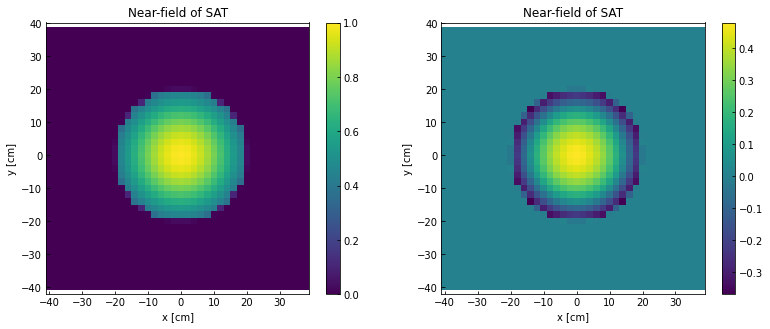

In [11]:
sb2_data = ray_trace.sim_data(sb2,80,2)

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.pcolormesh(sb2_data.x_data, sb2_data.y_data, np.abs(sb2_data.a_data), shading='auto')
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.subplot(122)
plt.pcolormesh(sb2_data.x_data, sb2_data.y_data, sb2_data.p_data, shading='auto')
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.show()


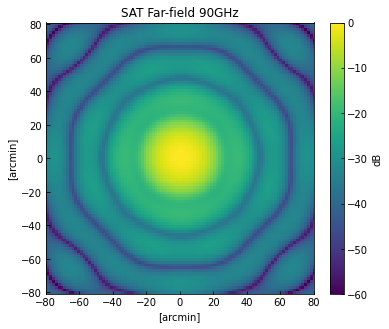

In [12]:
pix_num = 100
x_new, y_new, beam_data = opt_analyze.zero_pad(sb2_data.x_data, sb2_data.y_data, sb2_data.a_data, pix_num)
x_data, y_data, phase_data = opt_analyze.zero_pad(sb2_data.x_data,sb2_data.y_data, sb2_data.p_data, pix_num)
beam_fft, phase_fft = opt_analyze.a2b(beam_data, np.rad2deg(phase_data))
x_ang, y_ang = opt_analyze.coords_spat_to_ang(
    x_data / 1e2, y_data / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
)

plt.figure(figsize=(6, 5))
plt.title("SAT Far-field 90GHz")
plt.pcolormesh(
    x_ang * 180 * 60 / np.pi,
    y_ang * 180 * 60 / np.pi,
    20 * np.log10(abs(beam_fft) / np.max(abs(beam_fft))),
    vmin=-60,
    shading="auto",
)
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label="dB")
plt.axis("equal")
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.show()

## Predicted Beam Size
Our simulated beam size determines the resolution of our telescope.  We can compare this to the beam size of an Airy disc with aperture $D$ at wavelength $\lambda$:

$$\theta_{FWHM} = 1.025 \frac{\lambda}{D} $$

In [13]:
fwhm_est = ray_trace.ff_fwhm_est(beam_fft, x_ang, y_ang)
print("Estimated FWHM: {:.2f} arcmin".format(fwhm_est))

Estimated FWHM: 19.85 arcmin


### Now for multiple frequencies:

In [9]:
freq_arr = [85, 90, 95, 102, 106, 110, 115, 130, 135, 140]

for ii,freq in enumerate(freq_arr):

    tele_geo.lambda_ = opt_analyze.ghz_to_m(freq)
    tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa
    rx = [0,0,0]  # receiver feed position in focal plane [mm]
    
    sb = ray_trace.getNearField(tele_geo, rx,plot=False) # get near field
    sb2 = ray_trace.sim2d(sb) # get 2d near field
    sb2_data = ray_trace.sim_data(sb2,80,2)

    pix_num = 100
    x_new, y_new, beam_data = opt_analyze.zero_pad(sb2_data.x_data, sb2_data.y_data, sb2_data.a_data, pix_num)
    x_data, y_data, phase_data = opt_analyze.zero_pad(sb2_data.x_data,sb2_data.y_data, sb2_data.p_data, pix_num)
    beam_fft, phase_fft = opt_analyze.a2b(beam_data, np.rad2deg(phase_data))
    x_ang, y_ang = opt_analyze.coords_spat_to_ang(
        x_data / 1e2, y_data / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
    )
    fwhm_est = ray_trace.ff_fwhm_est(beam_fft, x_ang, y_ang)
    # print("Estimated FWHM: {:.2f} arcmin".format(fwhm_est))


100%|██████████| 2500/2500 [00:03<00:00, 675.86it/s]
